<a href="https://colab.research.google.com/github/Wupadova/Machine-and-Deep-Learning-Mod.B-/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in HW4.

In [ ]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [ ]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

170508288/170498071 [==============================] - 4s 0us/step


## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [ ]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [ ]:
ENCODING_DIM = 256

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00150
Test mse: 0.00153


In [ ]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

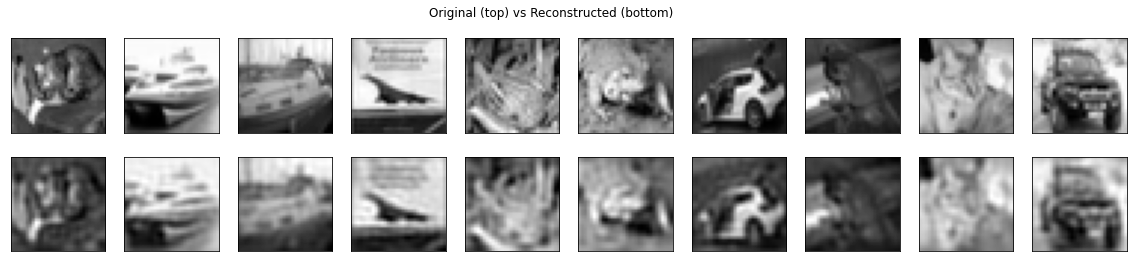

In [ ]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]**: What happens by varying the `ENCODING_DIM`? Try it out and discuss the results in this cell.

_Answer:_ The higher the dimension is, the better quality the reconstruction is. As the compressed data constains more information of the original data with a higher encoding dimension, hence during construction, more information about the original data is passed thus resulting in a better reconstruction quality.


We can see that as the encoding dimension decreases, both the training and the test MSE starts to increases, and as a result, the quality of the reconstruced pictures becomes worse. 

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 4s 39ms/step - loss: 0.1866 - val_loss: 0.0337
Epoch 2/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0444 - val_loss: 0.0215
Epoch 3/15
79/79 [==============================] - 3s 36ms/step - loss: 0.0237 - val_loss: 0.0169
Epoch 4/15
79/79 [==============================] - 4s 46ms/step - loss: 0.0154 - val_loss: 0.0142
Epoch 5/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0131 - val_loss: 0.0122
Epoch 6/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/15
79/79 [==============================] - 3s 34ms/step - loss: 0.0105 - val_loss: 0.0179
Epoch 8/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0098 - val_loss: 0.0089
Epoch 9/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 10/15
79/79 [==============================] - 3s 40ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0066 - 778ms/epoch - 2ms/step
Test mse: 0.00660


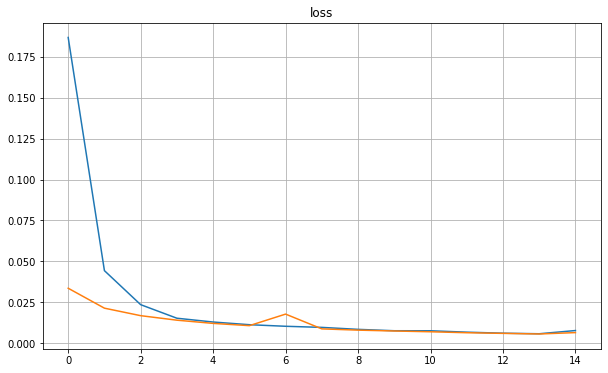

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

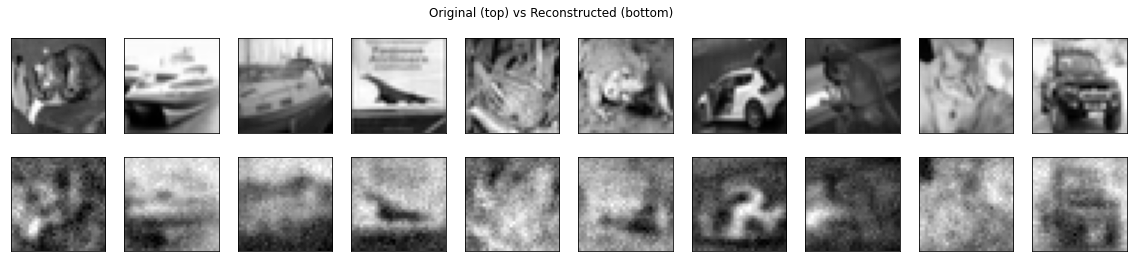

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]** Check the results and compare them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


_Answer:_ By setting the encoding dimension both to 256, the SVD model outperforms our shallow linear autoencoder. The main difference between those two methods is that the SVD used a direct matrix decomposition and the autoencoder uses a neural network to obtain the final result.

The performance of our autoencoder is not as good is because that we are using a linear model which might not process our dataset so well.

##[TO COMPLETE] Exercise 5.3: Shallow Non-linear Autoencoders

**[TO COMPLETE]** Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. 

Insert your code and theoretical discussion into cells immediately below this one.


The sigmoid function is used as the non-linear activation function, since it provides the best performance.  Moreover, after trying with other non linear activation function such as the softmax function, we get a MSE = 0.28304 which is way higher than the result obtained with the sigmoid function, this might due to the fact that our dataset does not have the label and we do not use the one-hot encoidng method which might hinder the performance of the softmax function.

As for the performance, the non-linear autoencoder performs similarly as the linear one, more precisely it is slightly better than the linear autoencoder but not by a sufficiently large margin, this might suggests that our dataset does not pocesse enough non-linearity which in the end the performance of the non-linear autoencoder is hindered.

Epoch 1/15
79/79 [==============================] - 4s 40ms/step - loss: 0.0343 - val_loss: 0.0217
Epoch 2/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0193 - val_loss: 0.0166
Epoch 3/15
79/79 [==============================] - 3s 40ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 4/15
79/79 [==============================] - 3s 40ms/step - loss: 0.0129 - val_loss: 0.0116
Epoch 5/15
79/79 [==============================] - 3s 40ms/step - loss: 0.0112 - val_loss: 0.0140
Epoch 6/15
79/79 [==============================] - 3s 35ms/step - loss: 0.0123 - val_loss: 0.0097
Epoch 7/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 8/15
79/79 [==============================] - 3s 40ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 9/15
79/79 [==============================] - 3s 40ms/step - loss: 0.0085 - val_loss: 0.0120
Epoch 10/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0082 - val_loss: 0.0106
Epoch 11/

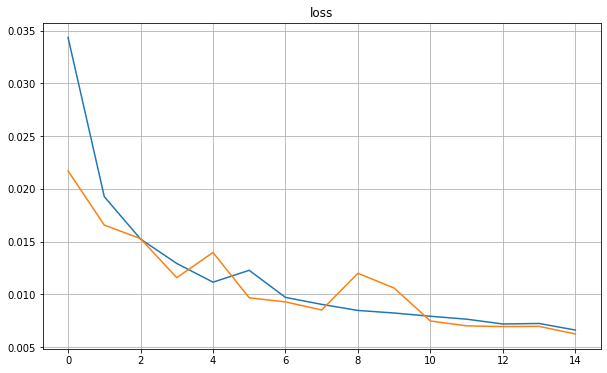

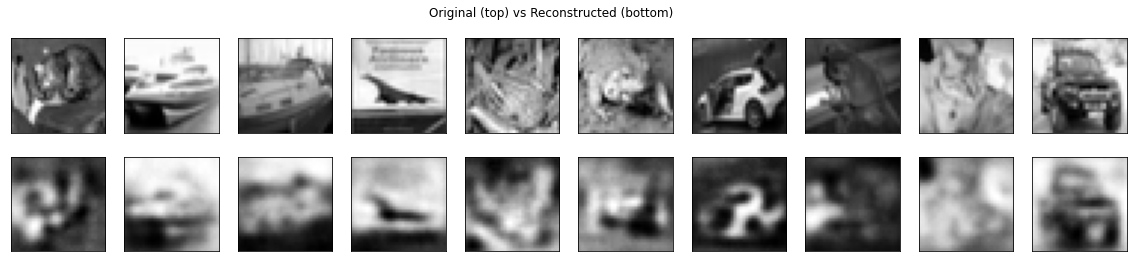

In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]** Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))

# Define the encoder...

encoded1 = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded2 = tf.keras.layers.Dense(64, activation='sigmoid')(encoded1)
# ...the decoder...
decoded1 = tf.keras.layers.Dense(128, activation='relu')(encoded2)
decoded2 = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(decoded1)
#[TO COMPLETE]
autoencoder = tf.keras.models.Model(input_img, decoded2) #[TO COMPLETE]

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_26 (Dense)            (None, 128)               131200    
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 128)               8320      
                                                                 
 dense_29 (Dense)            (None, 1024)              132096    
                                                                 
Total params: 279,872
Trainable params: 279,872
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 3s 27ms/step - loss: 0.0351 - val_loss: 0.0271
Epoch 2/15
79/79 [==============================] - 2s 26ms/step - loss: 0.0243 - val_loss: 0.0224
Epoch 3/15
79/79 [==============================] - 2s 25ms/step - loss: 0.0210 - val_loss: 0.0198
Epoch 4/15
79/79 [==============================] - 3s 36ms/step - loss: 0.0192 - val_loss: 0.0188
Epoch 5/15
79/79 [==============================] - 2s 28ms/step - loss: 0.0181 - val_loss: 0.0176
Epoch 6/15
79/79 [==============================] - 2s 27ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 7/15
79/79 [==============================] - 2s 28ms/step - loss: 0.0166 - val_loss: 0.0163
Epoch 8/15
79/79 [==============================] - 2s 28ms/step - loss: 0.0161 - val_loss: 0.0156
Epoch 9/15
79/79 [==============================] - 2s 29ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 10/15
79/79 [==============================] - 2s 25ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 11/

313/313 - 1s - loss: 0.0140 - 597ms/epoch - 2ms/step
test mse: 0.01397


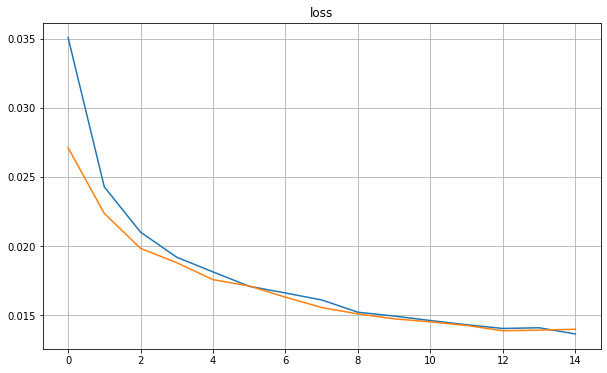

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

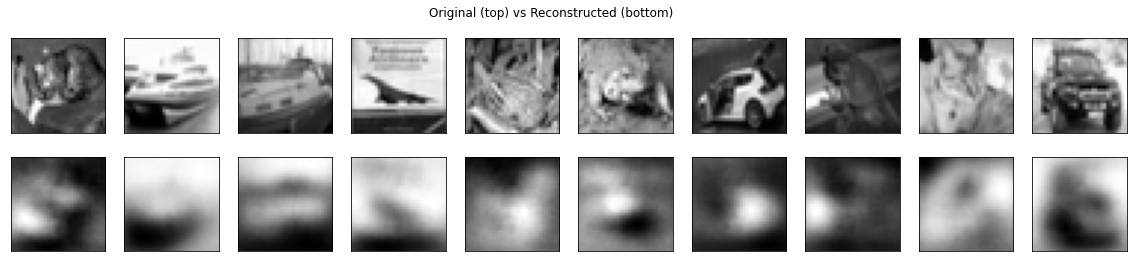

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [ ]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

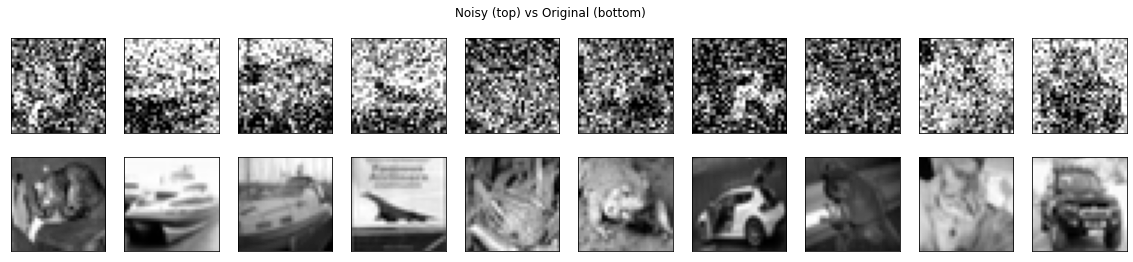

In [ ]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$). 

In [ ]:
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)
#[TO COMPLETE]
autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse') #[TO COMPLETE]

In [ ]:
autoencoder.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_30 (Dense)            (None, 256)               262400    
                                                                 
 dense_31 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train_noisy, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid_noisy, x_valid_noisy)) #[TO COMPLETE]

Epoch 1/15
79/79 [==============================] - 4s 44ms/step - loss: 0.0892 - val_loss: 0.0797
Epoch 2/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0785 - val_loss: 0.0742
Epoch 3/15
79/79 [==============================] - 3s 40ms/step - loss: 0.0730 - val_loss: 0.0720
Epoch 4/15
79/79 [==============================] - 3s 40ms/step - loss: 0.0689 - val_loss: 0.0676
Epoch 5/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0661 - val_loss: 0.0651
Epoch 6/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0637 - val_loss: 0.0623
Epoch 7/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0615 - val_loss: 0.0618
Epoch 8/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0596 - val_loss: 0.0591
Epoch 9/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0583 - val_loss: 0.0583
Epoch 10/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0572 - val_loss: 0.0593
Epoch 11/

313/313 - 1s - loss: 0.0194 - 1s/epoch - 3ms/step
Test mse: 0.01941


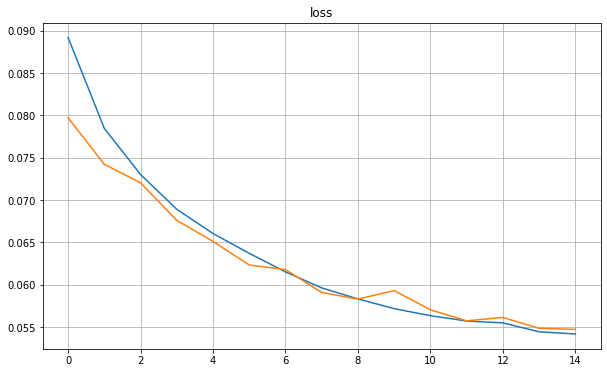

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

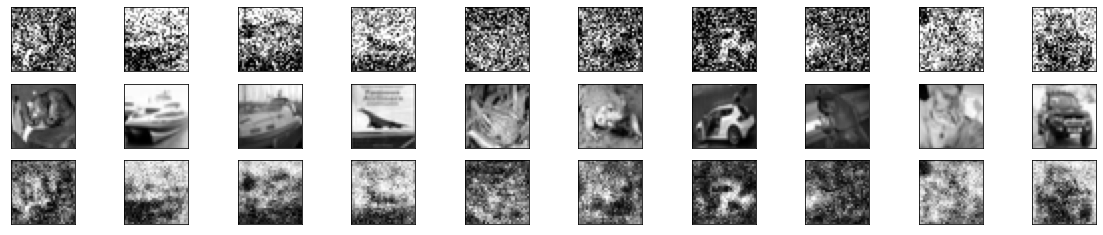

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

1654784/1641221 [==============================] - 0s 0us/step


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 90, 50)            7550      
                                                                 
 time_distributed (TimeDistr  (None, 90, 100)          5100      
 ibuted)                                                         
                                                                 
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 9s 92ms/step - loss: 0.1484 - categorical_accuracy: 0.1629 - val_loss: 0.0745 - val_categorical_accuracy: 0.4271
Epoch 2/50
79/79 [==============================] - 7s 90ms/step - loss: 0.0614 - categorical_accuracy: 0.4916 - val_loss: 0.0552 - val_categorical_accuracy: 0.5160
Epoch 3/50
79/79 [==============================] - 7s 90ms/step - loss: 0.0503 - categorical_accuracy: 0.5597 - val_loss: 0.0470 - val_categorical_accuracy: 0.5695
Epoch 4/50
79/79 [==============================] - 7s 95ms/step - loss: 0.0432 - categorical_accuracy: 0.5897 - val_loss: 0.0412 - val_categorical_accuracy: 0.6018
Epoch 5/50
79/79 [==============================] - 8s 98ms/step - loss: 0.0382 - categorical_accuracy: 0.6311 - val_loss: 0.0365 - val_categorical_accuracy: 0.6437
Epoch 6/50
79/79 [==============================] - 7s 90ms/step - loss: 0.0340 - categorical_accuracy: 0.6540 - val_loss: 0.0328 - val_categorical_accuracy: 0.6806
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0125 - categorical_accuracy: 0.9219 - 494ms/epoch - 12ms/step
categorical_accuracy: 92.19%


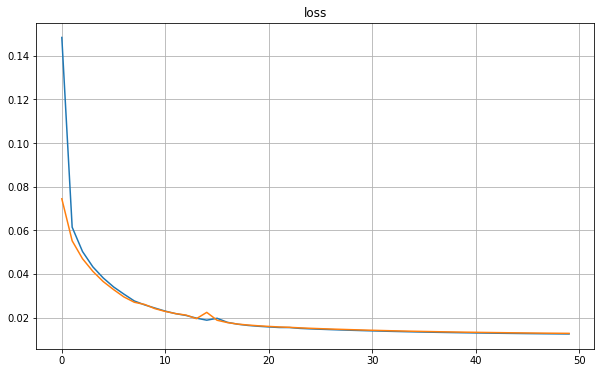

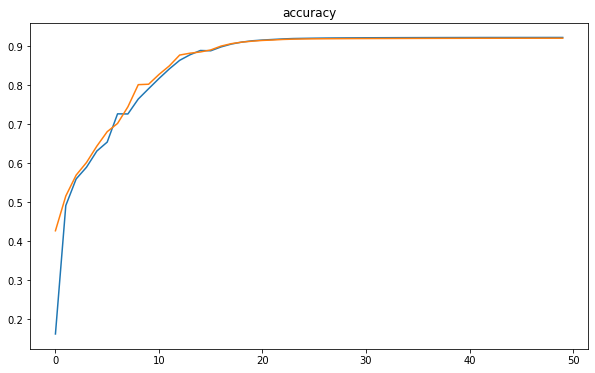

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> a <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as are other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this film a really like film that <oov> <oov> <oov> than <oov> <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

## The softmax function is used for the LSTM layer and since the one-hot encoding is used thus we selected the softmax function for the decoder. Furthermore, the loss we used is the categorical crossentropy method it is also due to the fact that we are using the one-hot encoding.

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='sigmoid')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='CategoricalCrossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 90, 100)]         0         
                                                                 
 lstm_7 (LSTM)               (None, 90, 50)            30200     
                                                                 
 time_distributed_7 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 [==============================] - 12s 143ms/step - loss: 3.2333 - categorical_accuracy: 0.4584 - val_loss: 2.8232 - val_categorical_accuracy: 0.4614
Epoch 2/50
79/79 [==============================] - 10s 130ms/step - loss: 2.7406 - c

40/40 - 1s - loss: 0.0024 - categorical_accuracy: 1.0000 - 656ms/epoch - 16ms/step
categorical_accuracy: 100.00%


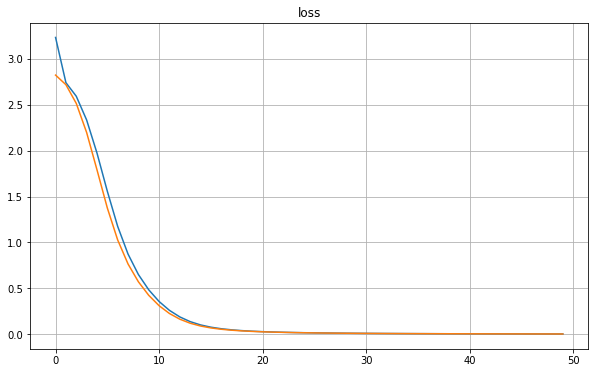

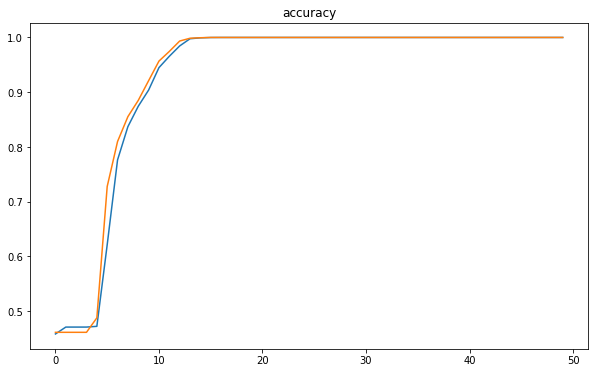

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))